# Baseline for LimeSoda: TF-IDF + nbSVM

## Installing dependencies

In [1]:
!pip install -q pythainlp sklearn tqdm pandas torch emoji seaborn

In [2]:
%cd /samsung-ssd/works/cp-master/pattern/course-projects
import json
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm

from baseline.tokenizer import tokenize
from baseline.model import NbSVC, NbLogisticRegression
from baseline.evaluate import evaluate

KAGGLE_DIR = "/samsung-ssd/works/cp-master/pattern/course-projects/dataset/Kaggle/"
DELIMITER = " "

/samsung-ssd/works/cp-master/pattern/course-projects


## Preparing Data

In [110]:
def read_kaggle_data():
    train = pd.read_csv(f"{KAGGLE_DIR}/train.csv").set_index("id")
    test = pd.read_csv(f"{KAGGLE_DIR}/test.csv").set_index("id")
    return train, test

In [111]:
train_data, test_data = read_kaggle_data()

In [112]:
train_data.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [113]:
test_data.isna().sum()

title     122
author    503
text        7
dtype: int64

In [114]:
train_data.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [115]:
# drop na
train_data = train_data[~train_data["title"].isna()]
test_data = test_data.fillna("")

## EDA

<AxesSubplot:ylabel='label'>

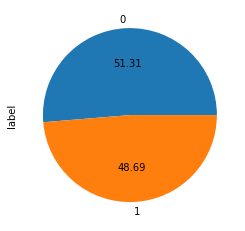

In [116]:
train_data["label"].value_counts().plot.pie(autopct="%.2f")

In [117]:
train_data.isna().sum()

title        0
author    1957
text        39
label        0
dtype: int64

In [118]:
test_data.isna().sum()

title     0
author    0
text      0
dtype: int64

## Data Splitting

In [153]:
train, val = train_test_split(train_data, train_size=2698, stratify=train_data["label"], random_state=1234)

In [154]:
len(train), len(val)

(2698, 17544)

In [155]:
x_train, y_train = train["title"].values, train["label"].values
x_val, y_val = val["title"].values, val["label"].values
x_test = test["title"].values

## Definining Pipeline

In [156]:
parameters_grid = {
    # tfidf grids
    "tfidf__ngram_range": [[1, 2]],
    "tfidf__min_df": [1, 3, 5, 7],
    "tfidf__max_df": [0.5, 0.6, 0.7, 0.8],
    "tfidf__use_idf": [True],
    "tfidf__smooth_idf": [True, False],
    "tfidf__sublinear_tf": [True, False],
    "tfidf__tokenizer": [lambda x: x.split(DELIMITER)],
    "tfidf__token_pattern": [None],

    # clf grids
    "clf__alpha": [0.5, 0.75],
    "clf__C": [1.],
}

In [157]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", NbLogisticRegression())
])

In [158]:
clf = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters_grid,
    scoring="accuracy",
    n_jobs=-1,
)

## Grid Search

In [159]:
clf.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', NbLogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [1.0], 'clf__alpha': [0.5, 0.75],
                         'tfidf__max_df': [0.5, 0.6], 'tfidf__min_df': [5, 7],
                         'tfidf__ngram_range': [[1, 2]],
                         'tfidf__smooth_idf': [True, False],
                         'tfidf__sublinear_tf': [True, False],
                         'tfidf__token_pattern': [None],
                         'tfidf__tokenizer': [<function <lambda> at 0x7f72c6605820>],
                         'tfidf__use_idf': [True]},
             scoring='accuracy')

In [160]:
clf.best_params_

{'clf__C': 1.0,
 'clf__alpha': 0.5,
 'tfidf__max_df': 0.5,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': [1, 2],
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': None,
 'tfidf__tokenizer': <function __main__.<lambda>(x)>,
 'tfidf__use_idf': True}

## Baseline
Mode prediction.

In [161]:
pd.Series(y_train).value_counts()

0    1384
1    1314
dtype: int64

In [169]:
print(classification_report(y_val, np.zeros_like(y_val), digits=4))

              precision    recall  f1-score   support

           0     0.5132    1.0000    0.6783      9003
           1     0.0000    0.0000    0.0000      8541

    accuracy                         0.5132     17544
   macro avg     0.2566    0.5000    0.3391     17544
weighted avg     0.2633    0.5132    0.3481     17544



/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/samsung-ssd/works/cp-master/pattern/course-projects/pattern-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

## Evaluation

In [163]:
y_pred = clf.predict(x_val)

In [164]:
results = evaluate(clf, x_val, y_val)
_ = results.pop("prediction")

In [165]:
results

{'accuracy': {'overall': 0.9194026447788418, 'average': 0.9212182755613485},
 'recall': {'micro': 0.9194026447788418, 'macro': 0.9212182755613485},
 'precision': {'micro': 0.9194026447788418, 'macro': 0.9266382586451215},
 'f1': {'micro': 0.9194026447788418, 'macro': 0.9192413709763951},
 'confusion_matrix': {'none': [[7673, 1330], [84, 8457]],
  'true': [[0.8522714650671999, 0.14772853493280017],
   [0.009834913944502985, 0.990165086055497]],
  'pred': [[0.9891710712904473, 0.13589455400020437],
   [0.010828928709552663, 0.8641054459997957]]}}

<AxesSubplot:>

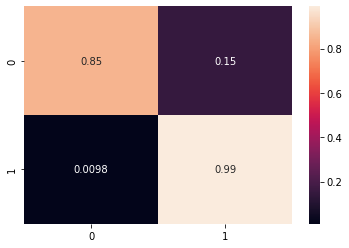

In [166]:
sns.heatmap(results["confusion_matrix"]["true"], annot=True)

In [167]:
submission = clf.predict(x_test)

In [168]:
pd.DataFrame(list(zip(test.index, submission)), columns=["id", "label"]).set_index("id").to_csv("notebooks/baseline.csv")

## Summary